In [1]:
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import scipy.stats as stats
import seaborn
import os
import re
import sys
import collections
import argparse
import tables
import itertools
import matplotlib
import numba
import pickle
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool
from random import shuffle
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools 
import scipy
import matplotlib
import glob
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scipy.io as io
import matplotlib.mlab as mlab
import pickle
import scanpy as sc

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

### Functions

In [2]:
def outlier_plot(ax, fc_list, plot_x_val, plot_y_val, outlier_idx, plot_idx, color):
    outlier_fc = np.array([])
    outlier_y_val = np.array([])
    outlier_x_val = np.array([])
        
    idx = np.intersect1d(plot_idx, outlier_idx)
    for j in idx:
        if fc_list[j] > 1:
            outlier_fc = np.append(outlier_fc, get_fc_range(fc_list[j]))
        else:
            outlier_fc = np.append(outlier_fc, get_fc_range(1/fc_list[j]))
            
        outlier_x_val = np.append(outlier_x_val, plot_x_val[j])
        outlier_y_val = np.append(outlier_y_val, plot_y_val[j])
        
    ax.scatter(outlier_x_val, outlier_y_val,
               color=color,
               s=outlier_fc,
               marker='o',
               edgecolor='w')

def get_fc_range(val):
    if (val >= 4):
        fc_range = 200
    elif (val >= 2):
        fc_range = 100
    else:
        fc_range = 50
    return fc_range

In [3]:
def hypergeo_test(non_zero_array, sgrna_idx, i):
    #find indecies of cells in which expression of given gene is
    #equal or less than the median of this gene in the whole population
    median_cell_idx  = np.argwhere(non_zero_array <= np.median(non_zero_array))

    #find the same cells subset in the cells with a given sgRNA
    overlap_cell_idx = np.intersect1d(median_cell_idx, sgrna_idx)
    
    #calculate the median fold change
    other_idx = np.setxor1d(sgrna_idx, range(len(non_zero_array)))
    
    fc = (np.mean(non_zero_array[sgrna_idx]) + 0.01) / (np.mean(non_zero_array[other_idx]) + 0.01)
    
    #perform hypergeometric test, get the upper tail
    k = len(overlap_cell_idx)
    M = len(non_zero_array)
    n = len(median_cell_idx)
    N = len(sgrna_idx)
    try:
        pval_up = stats.hypergeom.logcdf(k, M, n, N).item()
    except:
        pval_up = float('nan')
        
    try:
        pval_down = stats.hypergeom.logsf(k, M, n, N).item()
    except:
        pval_down = float('nan')
    
    return pval_down, pval_up, fc

In [4]:
def perform_DE(sgrna_idx, input_array, idx, num_processes, up_pval_list, down_pval_list):
    non_zero_up_pval_list = []
    non_zero_down_pval_list = []
    fc_list = []
    with Pool(processes=num_processes) as p:
        for down_pval, up_pval, fc in p.starmap(hypergeo_test, zip(input_array,
                                                                   itertools.repeat(sgrna_idx),
                                                                   idx)):
            non_zero_up_pval_list.append(up_pval)
            non_zero_down_pval_list.append(down_pval)
            fc_list.append(fc)
    for i in idx:
        up_pval_list[i] = non_zero_up_pval_list.pop(0)
        down_pval_list[i] = non_zero_down_pval_list.pop(0)
    return up_pval_list, down_pval_list, fc_list

### Genome Annotation

In [5]:
'''
Read parameters for figure plotting
'''
cmap = matplotlib.cm.get_cmap('Set2')

#create cumsum list of the chromsomal position
length_list = [0, 249250621, 492449994, 690472424, 881626700,
               1062541960, 1233657027, 1392795690, 1539159712,
               1680373143, 1815907890, 1950914406, 2084766301,
               2199936179, 2307285719, 2409817111, 2500171864,
               2581367074, 2659444322, 2718573305, 2781598825,
               2829728720, 2881033286, 3036303846]

chr_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20',
             '21', '22', 'X', 'Y']
        
#read the gene annotation file for plotting, which re-ordered the genes based on their
#relative positions on the genome
annot_df = pd.read_csv('plot_annotation.txt', 
                       header=None, 
                       sep='\t',
                       index_col=0,
                       names = ["gene_names", "chromosome", "pos", "strand", "color_idx", "sort_idx"])

### Load Processed Dataset

In [6]:
KO_DF = sc.read_h5ad('h5ad')

### Load Raw Data and Process

In [7]:
working_dir = '/outs/count/'

In [9]:
Raw_DS = sc.read_10x_h5(working_dir + 'filtered_feature_bc_matrix.h5', gex_only=False)
#### Rempves cellplex
Raw_DS = Raw_DS[:,:-12]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
Raw_DS = Raw_DS[KO_DF.obs.index]

In [11]:
Raw_DS.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
Raw_DS.obs_names_make_unique()

In [13]:
sc.pp.normalize_per_cell(Raw_DS, key_n_counts='n_counts_all') # normalize with total UMI count per cell # select highly-variable genes  # subset the genes

Raw_DS.raw = Raw_DS

### Process for hypergeometric test

In [14]:
Sample_Name = 'ENH5'

In [15]:
sg_cell_bc = KO_DF[KO_DF.obs['Sample'] == Sample_Name].obs.index

In [16]:
### Filter df to be only WT or target cells
passed_cells = []
for cell in KO_DF.obs.index:
    if KO_DF[cell].obs['Sample'].values[0] == Sample_Name or KO_DF[cell].obs['Sample'].values[0] == 'WT':
        passed_cells.append(cell)

In [17]:
Raw_DS = Raw_DS[passed_cells]

In [18]:
barcodes = np.asarray(Raw_DS.obs.index,dtype='str')
feature = np.asarray(Raw_DS.var.index, dtype='str')
sub_df = pd.DataFrame.sparse.from_spmatrix(data = Raw_DS.raw.X.T.tocsr(),columns = barcodes, index = feature)
idx = list(range(0,len(sub_df.index)))


sample_idx = []
for bc in sg_cell_bc:
    sample_idx.append(np.argwhere(sub_df.columns == bc)[0][0])
    
sample_idx = np.array(sample_idx)

up_pval_list   = [0] * (len(sub_df.index))
down_pval_list = [0] * (len(sub_df.index))

num_processing = 32

input_array = np.array(sub_df)[idx]

In [19]:
up_pval_list, down_pval_list, fc = perform_DE(sample_idx,
                                                  input_array,
                                                  idx,
                                                  num_processing,
                                                  up_pval_list,
                                                  down_pval_list)

In [20]:
up_idx        = np.where(np.array(fc) > 1)[0]
down_idx      = np.where(np.array(fc) < 1)[0]
plot_down_idx = np.intersect1d(down_idx, annot_df.index)
plot_up_idx   = np.intersect1d(up_idx, annot_df.index)

adj_up_pval = np.asarray(up_pval_list)
adj_up_pval[np.argwhere(adj_up_pval == 0)] = 1
adj_up_pval[np.isinf(adj_up_pval)] = 0
adj_up_pval[np.isnan(adj_up_pval)] = 0
pval_up_adj = -adj_up_pval


adj_down_pval = np.asarray(down_pval_list)
adj_down_pval[np.argwhere(adj_down_pval == 0)] = 1
adj_down_pval[np.isinf(adj_down_pval)] = 0
adj_down_pval[np.isnan(adj_down_pval)] = 0
pval_down_adj = -adj_down_pval

#calculate the p_value for plotting
plot_y_val = [0] * (len(fc))

for i in up_idx:
    plot_y_val[i] = pval_up_adj[i]

for i in down_idx:
    plot_y_val[i] = -pval_down_adj[i]


plot_y_val=np.array(plot_y_val) / np.log(10) #convert the p-values to 10-based log.
plot_x_val=np.array(annot_df.pos)

odd_idx = annot_df.index[annot_df.color_idx == 0]
even_idx= annot_df.index[annot_df.color_idx == 1]

In [21]:
region = 'TBX5'
num_sgrna_cell = len(sample_idx)
enh_chrom, left, right = ('chr12', '114353911', '114408442')

up_cutoff = 5
down_cutoff = 5

In [22]:
### Genes To Plot
Gene_Query = Gene_List_Exon

specific_raw_outliers = []
for gene in Gene_Query:
    specific_raw_outliers.append(np.argwhere(Raw_DS.raw.var_names == gene)[0][0])

NameError: name 'Gene_List_Exon' is not defined

/home2/s425140/.conda/envs/Hope/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home2/s425140/.conda/envs/Hope/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator


NameError: name 'specific_raw_outliers' is not defined

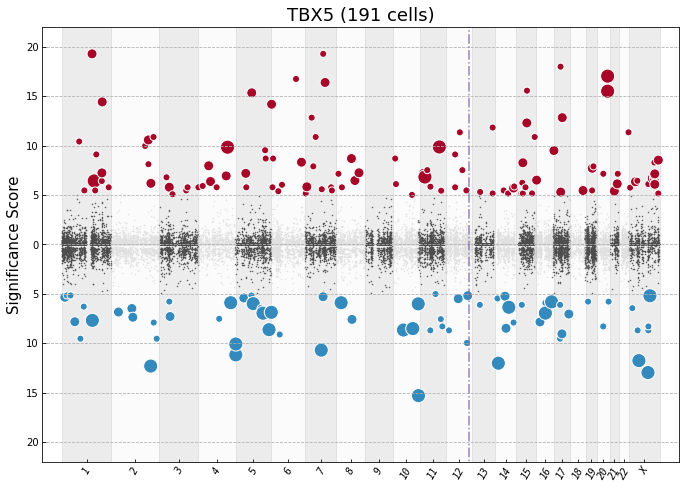

In [23]:
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(nrows=1, ncols=11)

#plot all genes
ax0 = fig.add_subplot(gs[:, 0:9])

ax0.scatter(plot_x_val[odd_idx],
           plot_y_val[odd_idx],
           s=1,
           color='#4d4d4d',
           marker='.')

ax0.scatter(plot_x_val[even_idx],
           plot_y_val[even_idx],
           s=1,
           color='#e0e0e0',
           marker='.')

ax0.set_title('%s (%d cells)'%(region, num_sgrna_cell),
             fontsize=18)

ax0.set_ylabel('Significance Score',
              fontsize = 15)

#configurate the axis
[ymin, ymax] = ax0.get_ylim()
max_yval = max([np.absolute(ymin), np.absolute(ymax)])
ax0.set_ylim([round(-max_yval-1),round(max_yval+1)])
#ax0.set_ylim([-30, 30])
ax0.set_xlim([-1e8, length_list[-1] + 1e8])
[ymin, ymax] = ax0.get_ylim()
ax0.tick_params(direction='in')
[xmin, xmax] = ax0.get_xlim()


#ax0.set_ylim([-30, 65])
#use absolute value for the y-axis
corrected_ylabels = np.array([])
labels = [np.absolute(int(i)) for i in ax0.get_yticks()]

ax0.set_yticklabels(labels)

#change the x-axis labels to chromosome names
xtick_pos = np.array([])
for i,e in enumerate(length_list):
    if i == 0:
        continue
    chrom_midpoint = (length_list[i-1] + e) / 2
    xtick_pos = np.append(xtick_pos, chrom_midpoint)

print_ChrNames = np.array([])
for i in chr_order:
    print_ChrNames = np.append(print_ChrNames, i[:1].upper() + i[1:])

ax0.set_xticklabels(print_ChrNames, 
                    rotation='60',
                    va='top',
                    ha='center',
                    style='oblique',
                    family='monospace')

for i,e in enumerate(length_list):
    if i == 0:
        continue
    if i % 2 == 0:
        ax0.fill_betweenx([ymin, ymax],
                          [length_list[i-1], length_list[i-1]],
                          [e, e],
                          color='#e0e0e0',
                          alpha=0.1)
    if i % 2 == 1:
        ax0.fill_betweenx([ymin, ymax],
                          [length_list[i-1], length_list[i-1]],
                          [e, e],
                          color='#4d4d4d',
                          alpha=0.1)
#setup the grid
#[s.set_visible(False) for s in ax0.spines.values()]
ax0.yaxis.grid(linestyle = '--')
ax0.set_xticks(xtick_pos)

#plot a vertical line at the position of enhancer
ax0.axvline(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))],
           color = '#7A68A6',
           ymin=ymin,
           ymax=ymax,
           linestyle='-.',
           alpha = 0.8)

#plot the outliers
raw_outliers = []
counter = 0
for i,e in enumerate(plot_y_val):
    if (e < (-1* down_cutoff) or e > up_cutoff):
        raw_outliers.append(counter)
    counter += 1

### Highlight hits past cutoff
outliers = np.intersect1d(raw_outliers, annot_df.index)
if np.any(outliers):

    outlier_plot(ax0, fc, plot_x_val, plot_y_val, outliers, plot_up_idx, '#A60628')
    outlier_plot(ax0, fc, plot_x_val, plot_y_val, outliers, plot_down_idx, '#348ABD')
    

#Show names
outliers = np.intersect1d(specific_raw_outliers, annot_df.index)
if np.any(outliers):
    for j in outliers:
        if (plot_y_val[j] > 1) or (plot_y_val[j] < -1):
            gene_name = annot_df.loc[annot_df.index == j].iloc[0].gene_names
            gene_chr = annot_df.loc[annot_df.index == j].iloc[0].chromosome

            if plot_y_val[j] > 0:
                ax0.text(plot_x_val[j] + (xmax*0.01), plot_y_val[j] + (ymax*0.01),
                         '%s'%(gene_name),
                         color = '#A60628',
                         fontsize=15)
            else:
                ax0.text(plot_x_val[j] + (xmax*0.01), plot_y_val[j] + (ymax*0.01),
                         '%s'%(gene_name),
                         color='#348ABD',
                         fontsize=15)


#manually plot a gene
'''ax0.scatter(plot_x_val[19997],
            plot_y_val[19997],
            s=20,
            color='k',
            edgecolor='w',
            marker='o')'''

#plot a legend for the circle size
ax1 = fig.add_subplot(gs[:,10])

y_len = ymax - ymin
y_val = []
for i in range(0,4):
    y_val.append(ymax - y_len * ((i + 1) * 0.05))

size = [150, 80, 30, 1]
legend_text = ['>=4-fold', '>=2-fold',
               '<2-fold', 'not significant']
for i,size in enumerate(size):
    ax1.scatter(0.5, y_val[i], 
                color = 'k',
                s=size,
                marker='o')
    ax1.text(0.7, y_val[i],
             '%s'%(legend_text[i]),
             ha='left',
             va='center',
             fontsize = 12)

ax1.axis('off')
ax1.set_ylim([ymin, ymax])
ax1.set_xlim([0.1,1])
ax1.set_title("Mean CPM FC",
              ha='left',
              va='bottom',
              fontsize = 15)

bbox_props=dict(boxstyle = 'round', fc='#348ABD', ec='0.5', alpha=0.85)
ax0.text(max(plot_x_val)*1.05, ymin*0.5, "Down Genes",
         ha='left',
         va='center',
         color='w',
         fontsize=15,
         rotation = 90,
         bbox=bbox_props)

bbox_props=dict(boxstyle = 'round', fc='#A60628', ec='0.5', alpha=0.85)
ax0.text(max(plot_x_val)*1.05, ymax*0.5, "Up Genes",
         ha='left',
         va='center',
         color='w',
         fontsize=15,
         rotation = 90,
         bbox=bbox_props)


#fig.savefig('/project/GCRB/Hon_lab/s425140/04.Figures/Cardio_Diff/Second_Knockout/5I_KO_CM_' + Sample_Name + '.dual_manhattan.ver2.pdf')

/home2/s425140/.conda/envs/Hope/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
/home2/s425140/.conda/envs/Hope/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


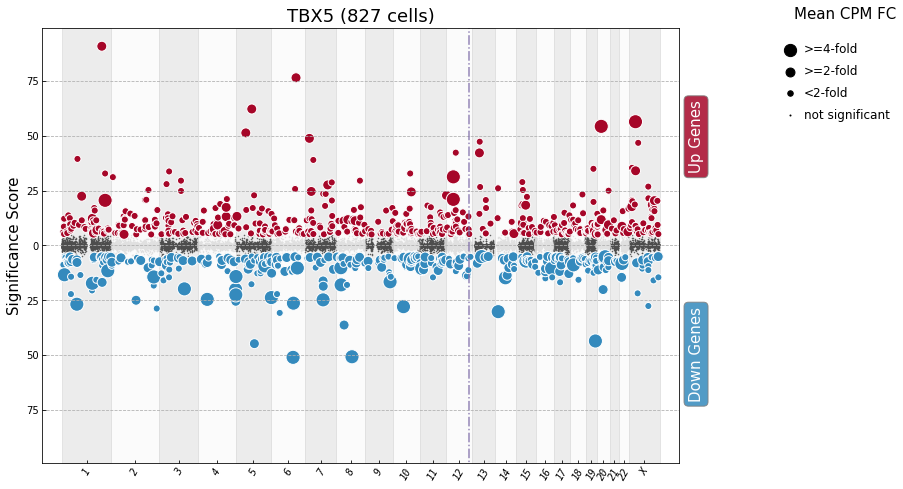

In [74]:
### No gene labels

fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(nrows=1, ncols=11)

#plot all genes
ax0 = fig.add_subplot(gs[:, 0:9])

ax0.scatter(plot_x_val[odd_idx],
           plot_y_val[odd_idx],
           s=1,
           color='#4d4d4d',
           marker='.')

ax0.scatter(plot_x_val[even_idx],
           plot_y_val[even_idx],
           s=1,
           color='#e0e0e0',
           marker='.')

ax0.set_title('%s (%d cells)'%(region, num_sgrna_cell),
             fontsize=18)

ax0.set_ylabel('Significance Score',
              fontsize = 15)

#configurate the axis
[ymin, ymax] = ax0.get_ylim()
max_yval = max([np.absolute(ymin), np.absolute(ymax)])
ax0.set_ylim([round(-max_yval-1),round(max_yval+1)])
#ax0.set_ylim([-30, 30])
ax0.set_xlim([-1e8, length_list[-1] + 1e8])
[ymin, ymax] = ax0.get_ylim()
ax0.tick_params(direction='in')
[xmin, xmax] = ax0.get_xlim()


#ax0.set_ylim([-30, 65])
#use absolute value for the y-axis
corrected_ylabels = np.array([])
labels = [np.absolute(int(i)) for i in ax0.get_yticks()]

ax0.set_yticklabels(labels)

#change the x-axis labels to chromosome names
xtick_pos = np.array([])
for i,e in enumerate(length_list):
    if i == 0:
        continue
    chrom_midpoint = (length_list[i-1] + e) / 2
    xtick_pos = np.append(xtick_pos, chrom_midpoint)

print_ChrNames = np.array([])
for i in chr_order:
    print_ChrNames = np.append(print_ChrNames, i[:1].upper() + i[1:])

ax0.set_xticklabels(print_ChrNames, 
                    rotation='60',
                    va='top',
                    ha='center',
                    style='oblique',
                    family='monospace')

for i,e in enumerate(length_list):
    if i == 0:
        continue
    if i % 2 == 0:
        ax0.fill_betweenx([ymin, ymax],
                          [length_list[i-1], length_list[i-1]],
                          [e, e],
                          color='#e0e0e0',
                          alpha=0.1)
    if i % 2 == 1:
        ax0.fill_betweenx([ymin, ymax],
                          [length_list[i-1], length_list[i-1]],
                          [e, e],
                          color='#4d4d4d',
                          alpha=0.1)
#setup the grid
#[s.set_visible(False) for s in ax0.spines.values()]
ax0.yaxis.grid(linestyle = '--')
ax0.set_xticks(xtick_pos)

#plot a vertical line at the position of enhancer
ax0.axvline(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))],
           color = '#7A68A6',
           ymin=ymin,
           ymax=ymax,
           linestyle='-.',
           alpha = 0.8)




#plot the outliers
raw_outliers = []
counter = 0
for i,e in enumerate(plot_y_val):
    if (e < (-1* down_cutoff) or e > up_cutoff):
        raw_outliers.append(counter)
    counter += 1



### Highlight hits past cutoff
outliers = np.intersect1d(raw_outliers, annot_df.index)
if np.any(outliers):

    outlier_plot(ax0, fc, plot_x_val, plot_y_val, outliers, plot_up_idx, '#A60628')
    outlier_plot(ax0, fc, plot_x_val, plot_y_val, outliers, plot_down_idx, '#348ABD')
    



#manually plot a gene
'''ax0.scatter(plot_x_val[19997],
            plot_y_val[19997],
            s=20,
            color='k',
            edgecolor='w',
            marker='o')'''

#plot a legend for the circle size
ax1 = fig.add_subplot(gs[:,10])

y_len = ymax - ymin
y_val = []
for i in range(0,4):
    y_val.append(ymax - y_len * ((i + 1) * 0.05))

size = [150, 80, 30, 1]
legend_text = ['>=4-fold', '>=2-fold',
               '<2-fold', 'not significant']
for i,size in enumerate(size):
    ax1.scatter(0.5, y_val[i], 
                color = 'k',
                s=size,
                marker='o')
    ax1.text(0.7, y_val[i],
             '%s'%(legend_text[i]),
             ha='left',
             va='center',
             fontsize = 12)

ax1.axis('off')
ax1.set_ylim([ymin, ymax])
ax1.set_xlim([0.1,1])
ax1.set_title("Mean CPM FC",
              ha='left',
              va='bottom',
              fontsize = 15)

bbox_props=dict(boxstyle = 'round', fc='#348ABD', ec='0.5', alpha=0.85)
ax0.text(max(plot_x_val)*1.05, ymin*0.5, "Down Genes",
         ha='left',
         va='center',
         color='w',
         fontsize=15,
         rotation = 90,
         bbox=bbox_props)

bbox_props=dict(boxstyle = 'round', fc='#A60628', ec='0.5', alpha=0.85)
ax0.text(max(plot_x_val)*1.05, ymax*0.5, "Up Genes",
         ha='left',
         va='center',
         color='w',
         fontsize=15,
         rotation = 90,
         bbox=bbox_props)

fig.savefig('' + Sample_Name + '.dual_manhattan.ver2.png', dpi=600)

In [ ]:
gene_hits = []

for gene in raw_outliers:
    gene_hits.append(Raw_DS.raw.var_names[gene])

In [71]:
Gene_List_Exon = ['NPPA', 'TGFB2', 'TTN', 'MYL3', 'IRX1', 'IRX2', 'IRX4', 'MYL7', 'PLN', 'MYOF', 'MYH6', 'IRX3', 'IRX5', 'MYL9', 'ACTA2', 'HAS2']

In [43]:
Gene_List_ENH3 = ['TGFB2', 'COL3A1', 'IRX2', 'WNT2', 'MYL6', 'MYL7', 'IRX3', 'ACTA2']

In [22]:
Gene_List_ENH5 = ['IRX2', 'FN1', 'COL3A1', 'IRX3', 'IRX5', 'MYL9']

### Get Genes

In [88]:
raw_outliers_up = []
raw_outliers_down = []
counter = 0
for i,e in enumerate(plot_y_val):
    if ( e > up_cutoff):
        raw_outliers_up.append(counter)
        
    if (e < (-1* down_cutoff)):
        raw_outliers_down.append(counter)
    counter += 1
    
outliers_up = np.intersect1d(raw_outliers_up, annot_df.index)
outliers_down = np.intersect1d(raw_outliers_down, annot_df.index)

    

In [89]:
DOWN_DF = pd.DataFrame(data = annot_df.iloc[outliers_down]['gene_names'].values, columns=[['Genes_Up_Regulated']])
DOWN_DF['log10pval_Down_Regulated'] = plot_y_val[outliers_down]
DOWN_DF.to_csv('' + Sample_Name + '_DOWN_Manhattan_pvals.csv')

In [90]:
UP_DF = pd.DataFrame(data = annot_df.iloc[outliers_up]['gene_names'].values, columns=[['Genes_Up_Regulated']])
UP_DF['-log10pval_Up_Regulated'] = plot_y_val[outliers_up]
UP_DF.to_csv('' + Sample_Name + '_UP_Manhattan_pvals.csv')